In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import collections
import os

import mpl_stylesheet

mpl_stylesheet.banskt_presentation(fontfamily = 'system')

In [4]:
gene = 'ENSG00000023228'
outdir = 'cardiogenics_mono_macro/matrixeqtl/chr6'
ldfile = os.path.join(outdir, f"{gene}.ld")
metafile = os.path.join(outdir, f"{gene}.meta")
resfile = '/scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-mono/matrixeqtl/chr6/trans_eqtl.txt'
outfile = os.path.join(outdir, f"{gene}.png")

In [5]:
bp_list = list()
rsid_list = list()
pvals = list()
with open(metafile, 'r') as instream:
    next(instream)
    for line in instream:
        linesplit = line.split()
        bp_list.append(int(linesplit[2]))
        rsid_list.append(linesplit[1].strip())
locus_end = max(bp_list)
locus_start = min(bp_list)
onemb = 1000000
snppos = [x / onemb for x in bp_list]

pvalues = collections.defaultdict(lambda:0)
with open(resfile, 'r') as instream:
    next(instream)
    for line in instream:
        arr  = line.rstrip().split("\t")
        rsid = arr[0]
        target_gene = arr[1]
        pval = float(arr[4])
        fdr  = float(arr[5])
        if target_gene == gene:
            if rsid in rsid_list:
                pvalues[rsid] = -np.log10(pval)

X1 = list()
Y1 = list()
counter = 0
for i, rsid in enumerate(rsid_list):
    X1.append(snppos[i])
    Y1.append(pvalues[rsid])
    counter += 1

In [6]:
hm = np.loadtxt(ldfile)
n = locus_end - locus_start
divisor = int(n / 50)
n = int(n / divisor)
sparse_hm = np.zeros((n, n))
for i, rsid1 in enumerate(rsid_list):
    for j, rsid2 in enumerate(rsid_list):
        pos1 = bp_list[i] - locus_start
        pos2 = bp_list[j] - locus_start
        pos1 = min (n - 1, int(pos1 / divisor))
        pos2 = min (n - 1, int(pos2 / divisor))
        if abs(sparse_hm[pos1, pos2]) < abs(hm[i, j]):
            sparse_hm[pos1, pos2] = hm[i, j]
A = np.square(sparse_hm)
mask =  np.tri(A.shape[0], k=-1)
A = np.ma.array(A, mask=mask) # mask out the lower triangle

# http://stackoverflow.com/questions/12848581/is-there-a-way-to-rotate-a-matplotlib-plot-by-45-degrees
# Rotation matrix anticlockwise 135 degree
t = np.sqrt(0.5) * np.array([[-1, 1], [-1, -1]])
#t = np.array([[1,0], [0,1]])

# Create coordinate matrix and transform
n = A.shape[0]
coord = np.array([(i[1],i[0]) for i in itertools.product(range(n,-1,-1),range(0,n+1,1))])
new_coord = np.dot(coord, t)
X = new_coord[:,1].reshape(n+1, n+1)
Y = new_coord[:,0].reshape(n+1, n+1)

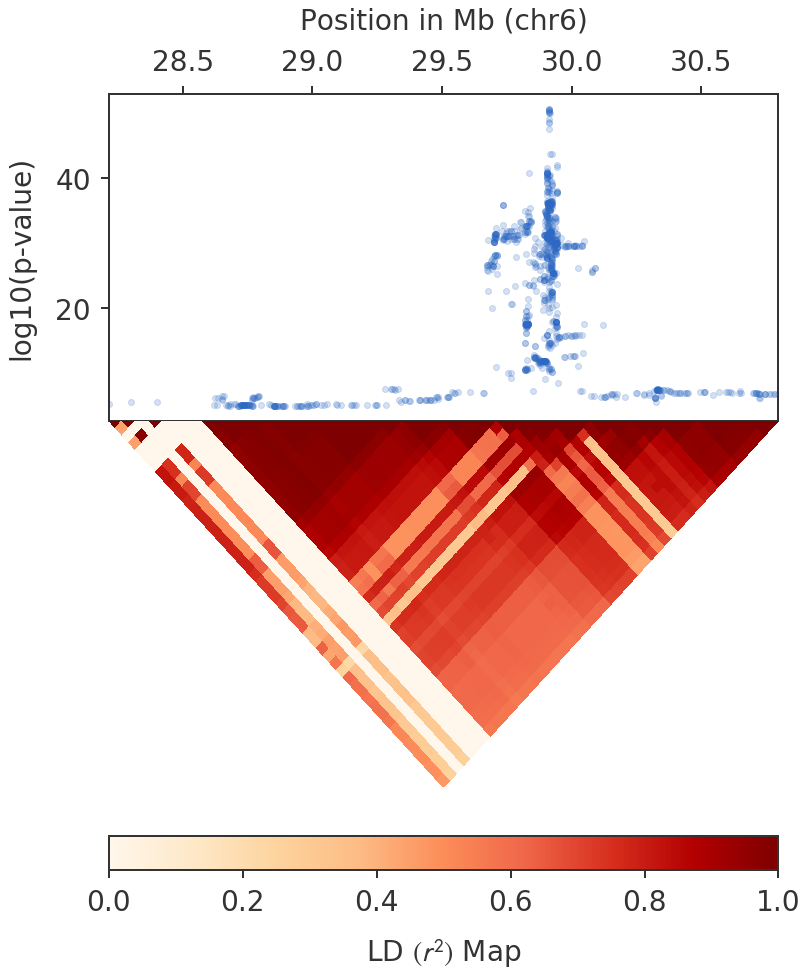

In [8]:
fig = plt.figure(num=None, figsize=(12, 15))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[0.8, 1.2])
gs.update(hspace=0.0)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

cmap = matplotlib.cm.get_cmap('OrRd')
cmap.set_bad('w') # default value is 'k'

ax1.scatter(X1, Y1, alpha = 0.2)
heatmap = ax2.pcolormesh(X, Y, A, cmap=cmap)
cbar = fig.colorbar(heatmap, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], orientation='horizontal', pad=0.1)
cbar.set_label(label = r'LD $(r^2)$ Map')


axes_xstart = locus_start / onemb
axes_xend = locus_end / onemb

ax1.set_xlim([axes_xstart, axes_xend])
ax2.set_xlim([np.min(X), np.max(X)])
ax2.set_ylim([np.min(Y), np.min(Y)/2])
ax2.axis('off')

ax1label = r'log10(p-value)'
ax1.set_ylabel(ax1label)
xlabel = 'Position in Mb (chr6)'
ax1.set_xlabel(xlabel)
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')

plt.savefig(outfile, bbox_inches='tight')
#plt.show()